## GAN
서로 대립하는 두 신경망을 경쟁시켜가며 결과물을 생성하는 GAN모델을 이용해 MNIST손글씨 숫자를 무작위로 생성해 봅시다.   
흔히 GAN을 위조지폐범과 경찰에 비유해 설명합니다. 위조지폐범(generator)은 경찰(discriminator)을 속이도록 학습하며 경찰(discriminator)은 위조지폐와 실제 지폐를 구분하도록 학습시킵니다. 이렇게 서로 대립하며 학습시키면 결국 위조지폐범(generator)은 실제지폐와 구분이 불가능한 위조지폐를 만들게 될겁니다.


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot = True)

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


먼저 필요한 라이브러리들을 불러줍니다.

In [0]:
total_epoch = 100
batch_size = 100
learning_rate = 0.0002
n_hidden = 256
n_input = 28*28
n_noise = 128

하이퍼 파라미터들을 설정해 줍니다. 마지막 ``n_noise``는 ``generator``의 입력값을 사용할 노이즈의 크기입니다.

In [0]:
X = tf.placeholder(tf.float32 , [None,n_input])
Z = tf.placeholder(tf.float32, [None, n_noise])

GAN역시 비지도 학습이므로 autoencoder와 같이 Y를 사용하지 않습니다. 다만 Discriminator에 넣을 이미지가 실제이미지와 가짜이미지(2개)이며 가짜이미지를 생성하기 위해 노이즈를 입력할 Z를 추가해줍니다.

In [0]:
G_W1 = tf.Variable(tf.random_normal([n_noise,n_hidden],stddev= 0.01))
G_b1 = tf.Variable(tf.zeros([n_hidden]))
G_W2 = tf.Variable(tf.random_normal([n_hidden, n_input],stddev = 0.01))
G_b2 = tf.Variable(tf.zeros([n_input]))

Generator 신경망에 사용할 변수들을 설정합니다. 첫번째는 노이즈 (입력,은닉층) 두번째는 (은닉층,출력)입니다. 우리는 실제이미지가 28x28크기이므로 생성자의 출력(가짜이미지:``n_input``)역시 ``28x28``의 크기를 가져야 합니다.

In [0]:
D_W1 = tf.Variable(tf.random_normal([n_input,n_hidden],stddev = 0.01))
D_b1 = tf.Variable(tf.zeros([n_hidden]))
D_W2 = tf.Variable(tf.random_normal([n_hidden,1],stddev=0.01))
D_b2 = tf.Variable(tf.zeros([1]))

Discriminator 신경망에 사용할 변수들을 설정합니다. 입력과 은닉층은 생성자와 동일하게 구성하며, 구분자는 진짜와 가짜가 얼마나 비슷한지 판단하는 값이므로 0~1사이의 값을 출력합니다. 

In [0]:
def generator(noise_z):
  hidden = tf.nn.relu(tf.matmul(noise_z,G_W1)+G_b1)
  output = tf.nn.sigmoid(tf.matmul(hidden,G_W2)+G_b2)
  return output

생성자의 신경망을 구성해 줍니다.   
생성자는 무작위로 생성한 노이즈를 받아 가중치와 편향을 반영하여 은닉층을 만든뒤 은닉층에서 실제 이미지와 같은크기(28x28)의 결과값을 출력합니다.

In [0]:
def discriminator(inputs):
  hidden = tf.nn.relu(tf.matmul(inputs,D_W1)+D_b1)
  output = tf.nn.sigmoid(tf.matmul(hidden,D_W2)+D_b2)
  return output


구분자 신경망 역시 같은 구성이지만 출력이 0~1사이의 스칼라값 출력을 위해 ``sigmoid``함수를 사용합니다.

In [0]:
def get_noise(batch_size, n_noise):
  return np.random.normal(size=(batch_size,n_noise))

무작위로 noise값을 바꿔줄 함수도 만들어 줍시다.

In [0]:
G = generator(Z)
D_gene = discriminator(G)
D_real = discriminator(X)

마지막으로 noise Z를 이용해 가까이미지(G)를 만들고 만든 가짜이미지(G)와 진짜이미지(X)를 각각 구분자에 넣어 입력이미지의 진짜or가짜여부를 판별하도록 만듭니다.

In [0]:
loss_D = tf.reduce_mean(tf.log(D_real)+ tf.log(1-D_gene))
loss_G = tf.reduce_mean(tf.log(D_gene))

이제 손실함수를 설정해주어야 합니다.   

- 구분자의 손실함수(``loss_D``)는 ``D_real``값은 ``1``에 가깝도록(진짜이미지를 1로판별) ``D_gene`` 값은 ``0``(가짜이미지는 0으로 판별)에 가까워야 합니다.
``D_real``값과 ``1 - D_gene``값의 합 ``loss_D``가 최대가 되도록 하면 구별자의 학습이 이루어집니다.   

- 생성자는 ``D_gene``값이 ``1``에 가깝도록(가짜이미지를 진짜(1)이라고 생각하도록)만들어야 하므로 ``loss_G``값이 최대가 되도록 하면 생성자의 학습이 이루어집니다.

즉, GAN의 학습은 ``loss_D``와 ``loss_G``값 모두 최대화 하는 것이지만 둘은 서로 대립하므로 어느 한쪽이 증가하면 어느한쪽은 감소하게 됩니다. 어느 한쪽의 값이 최대가 되도록 편향되지 않고 두 값의 학습이 적당히 잘 되어야만 좋은 GAN을 만들수 있습니다.

In [0]:
D_var_list = [D_W1,D_b1,D_W2,D_b2]
G_var_list = [G_W1,G_b1,G_W2,G_b2]

생성자와 구분자를 분리하여 학습시키기 위해 둘을 나누어 줍니다.*이탤릭체 텍스트*

In [0]:
train_D = tf.train.AdamOptimizer(learning_rate).minimize(-loss_D, var_list = D_var_list)
train_G = tf.train.AdamOptimizer(learning_rate).minimize(-loss_G, var_list= G_var_list)

우리는 ``loss_D``와 ``loss_G``를 **최대화** 시켜야 하지만 최적화에 쓸수있는 함수가 ``minimize``밖에 없으므로 ``-log(x)``값을 최소화 한다면 x값이 최대가 될것입니다.

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int( mnist.train.num_examples / batch_size)
loss_val_D, loss_val_G = 0,0

세션 설정과함께 미니배치를 만들고 loss_D 와 loss_G의 결과값을 받을 변수 ``loss_val_D``와 ``loss_val_G``를 설정해줍니다.

* * *
미니배치로 학습을 반복하도록 합니다.   
구분자는 X값을, 생성자는 노이즈 Z값을 받으므로 노이즈를 get_noise함수를 통해 배치크기만큼 노이즈를 만들고 넣어줍니다.

Epoch: 0000 D loss: -0.2352 G loss: -2.517


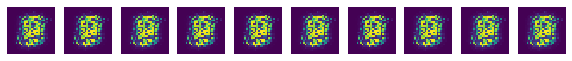

Epoch: 0001 D loss: -0.07748 G loss: -3.474


<Figure size 432x288 with 0 Axes>

Epoch: 0002 D loss: -0.4512 G loss: -1.811


<Figure size 432x288 with 0 Axes>

Epoch: 0003 D loss: -0.3817 G loss: -1.715


<Figure size 432x288 with 0 Axes>

Epoch: 0004 D loss: -0.3054 G loss: -2.194


<Figure size 432x288 with 0 Axes>

Epoch: 0005 D loss: -0.2167 G loss: -2.677


<Figure size 432x288 with 0 Axes>

Epoch: 0006 D loss: -0.1972 G loss: -2.842


<Figure size 432x288 with 0 Axes>

Epoch: 0007 D loss: -0.3811 G loss: -2.571


<Figure size 432x288 with 0 Axes>

Epoch: 0008 D loss: -0.3456 G loss: -2.355


<Figure size 432x288 with 0 Axes>

Epoch: 0009 D loss: -0.2947 G loss: -2.623


<Figure size 432x288 with 0 Axes>

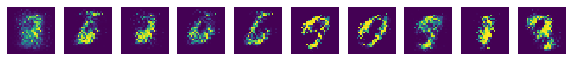

Epoch: 0010 D loss: -0.3258 G loss: -2.584


<Figure size 432x288 with 0 Axes>

Epoch: 0011 D loss: -0.2498 G loss: -3.217


<Figure size 432x288 with 0 Axes>

Epoch: 0012 D loss: -0.2891 G loss: -2.975


<Figure size 432x288 with 0 Axes>

Epoch: 0013 D loss: -0.2563 G loss: -2.89


<Figure size 432x288 with 0 Axes>

Epoch: 0014 D loss: -0.4237 G loss: -2.907


<Figure size 432x288 with 0 Axes>

Epoch: 0015 D loss: -0.2309 G loss: -3.338


<Figure size 432x288 with 0 Axes>

Epoch: 0016 D loss: -0.282 G loss: -3.012


<Figure size 432x288 with 0 Axes>

Epoch: 0017 D loss: -0.3697 G loss: -2.856


<Figure size 432x288 with 0 Axes>

Epoch: 0018 D loss: -0.2518 G loss: -3.038


<Figure size 432x288 with 0 Axes>

Epoch: 0019 D loss: -0.2319 G loss: -2.987


<Figure size 432x288 with 0 Axes>

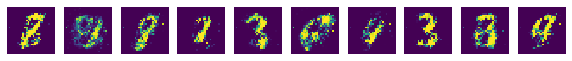

Epoch: 0020 D loss: -0.1918 G loss: -3.256


<Figure size 432x288 with 0 Axes>

Epoch: 0021 D loss: -0.3246 G loss: -2.654


<Figure size 432x288 with 0 Axes>

Epoch: 0022 D loss: -0.2387 G loss: -3.262


<Figure size 432x288 with 0 Axes>

Epoch: 0023 D loss: -0.2946 G loss: -2.802


<Figure size 432x288 with 0 Axes>

Epoch: 0024 D loss: -0.306 G loss: -3.026


<Figure size 432x288 with 0 Axes>

Epoch: 0025 D loss: -0.3545 G loss: -2.632


<Figure size 432x288 with 0 Axes>

Epoch: 0026 D loss: -0.2738 G loss: -3.039


<Figure size 432x288 with 0 Axes>

Epoch: 0027 D loss: -0.4989 G loss: -2.941


<Figure size 432x288 with 0 Axes>

Epoch: 0028 D loss: -0.3387 G loss: -2.755


<Figure size 432x288 with 0 Axes>

Epoch: 0029 D loss: -0.2943 G loss: -3.229


<Figure size 432x288 with 0 Axes>

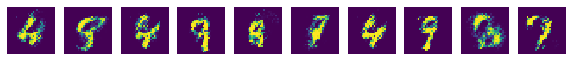

Epoch: 0030 D loss: -0.3075 G loss: -2.974


<Figure size 432x288 with 0 Axes>

Epoch: 0031 D loss: -0.4298 G loss: -3.209


<Figure size 432x288 with 0 Axes>

Epoch: 0032 D loss: -0.2786 G loss: -3.225


<Figure size 432x288 with 0 Axes>

Epoch: 0033 D loss: -0.399 G loss: -2.83


<Figure size 432x288 with 0 Axes>

Epoch: 0034 D loss: -0.3325 G loss: -3.236


<Figure size 432x288 with 0 Axes>

Epoch: 0035 D loss: -0.4255 G loss: -2.706


<Figure size 432x288 with 0 Axes>

Epoch: 0036 D loss: -0.435 G loss: -2.737


<Figure size 432x288 with 0 Axes>

Epoch: 0037 D loss: -0.489 G loss: -2.914


<Figure size 432x288 with 0 Axes>

Epoch: 0038 D loss: -0.5638 G loss: -2.563


<Figure size 432x288 with 0 Axes>

Epoch: 0039 D loss: -0.4234 G loss: -2.641


<Figure size 432x288 with 0 Axes>

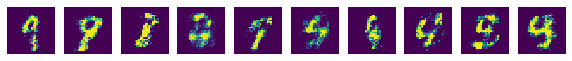

Epoch: 0040 D loss: -0.6462 G loss: -2.528


<Figure size 432x288 with 0 Axes>

Epoch: 0041 D loss: -0.4222 G loss: -2.98


<Figure size 432x288 with 0 Axes>

Epoch: 0042 D loss: -0.4484 G loss: -2.408


<Figure size 432x288 with 0 Axes>

Epoch: 0043 D loss: -0.4268 G loss: -2.85


<Figure size 432x288 with 0 Axes>

Epoch: 0044 D loss: -0.4507 G loss: -2.652


<Figure size 432x288 with 0 Axes>

Epoch: 0045 D loss: -0.7177 G loss: -2.73


<Figure size 432x288 with 0 Axes>

Epoch: 0046 D loss: -0.6225 G loss: -2.372


<Figure size 432x288 with 0 Axes>

Epoch: 0047 D loss: -0.5744 G loss: -2.412


<Figure size 432x288 with 0 Axes>

Epoch: 0048 D loss: -0.6374 G loss: -2.716


<Figure size 432x288 with 0 Axes>

Epoch: 0049 D loss: -0.6824 G loss: -2.11


<Figure size 432x288 with 0 Axes>

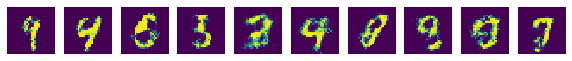

Epoch: 0050 D loss: -0.533 G loss: -2.717


<Figure size 432x288 with 0 Axes>

Epoch: 0051 D loss: -0.4662 G loss: -2.764


<Figure size 432x288 with 0 Axes>

Epoch: 0052 D loss: -0.5153 G loss: -2.535


<Figure size 432x288 with 0 Axes>

Epoch: 0053 D loss: -0.7425 G loss: -2.194


<Figure size 432x288 with 0 Axes>

Epoch: 0054 D loss: -0.4776 G loss: -2.4


<Figure size 432x288 with 0 Axes>

Epoch: 0055 D loss: -0.5682 G loss: -2.331


<Figure size 432x288 with 0 Axes>

Epoch: 0056 D loss: -0.5969 G loss: -2.452


<Figure size 432x288 with 0 Axes>

Epoch: 0057 D loss: -0.5172 G loss: -2.454


<Figure size 432x288 with 0 Axes>

Epoch: 0058 D loss: -0.4579 G loss: -2.773


<Figure size 432x288 with 0 Axes>

Epoch: 0059 D loss: -0.4162 G loss: -2.642


<Figure size 432x288 with 0 Axes>

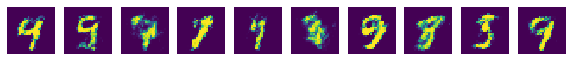

Epoch: 0060 D loss: -0.5868 G loss: -2.524


<Figure size 432x288 with 0 Axes>

Epoch: 0061 D loss: -0.6497 G loss: -2.225


<Figure size 432x288 with 0 Axes>

Epoch: 0062 D loss: -0.5385 G loss: -2.619


<Figure size 432x288 with 0 Axes>

Epoch: 0063 D loss: -0.6726 G loss: -2.2


<Figure size 432x288 with 0 Axes>

Epoch: 0064 D loss: -0.6027 G loss: -2.252


<Figure size 432x288 with 0 Axes>

Epoch: 0065 D loss: -0.6177 G loss: -2.596


<Figure size 432x288 with 0 Axes>

Epoch: 0066 D loss: -0.7004 G loss: -2.006


<Figure size 432x288 with 0 Axes>

Epoch: 0067 D loss: -0.5691 G loss: -2.336


<Figure size 432x288 with 0 Axes>

Epoch: 0068 D loss: -0.6571 G loss: -2.124


<Figure size 432x288 with 0 Axes>

Epoch: 0069 D loss: -0.5486 G loss: -2.41


<Figure size 432x288 with 0 Axes>

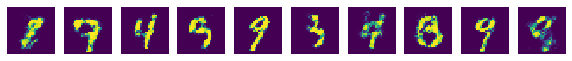

Epoch: 0070 D loss: -0.6992 G loss: -2.185


<Figure size 432x288 with 0 Axes>

Epoch: 0071 D loss: -0.7377 G loss: -2.222


<Figure size 432x288 with 0 Axes>

Epoch: 0072 D loss: -0.7698 G loss: -2.209


<Figure size 432x288 with 0 Axes>

Epoch: 0073 D loss: -0.5301 G loss: -2.367


<Figure size 432x288 with 0 Axes>

Epoch: 0074 D loss: -0.5161 G loss: -2.165


<Figure size 432x288 with 0 Axes>

Epoch: 0075 D loss: -0.688 G loss: -2.145


<Figure size 432x288 with 0 Axes>

Epoch: 0076 D loss: -0.6271 G loss: -2.252


<Figure size 432x288 with 0 Axes>

Epoch: 0077 D loss: -0.7214 G loss: -1.762


<Figure size 432x288 with 0 Axes>

Epoch: 0078 D loss: -0.7146 G loss: -2.161


<Figure size 432x288 with 0 Axes>

Epoch: 0079 D loss: -0.5835 G loss: -2.345


<Figure size 432x288 with 0 Axes>

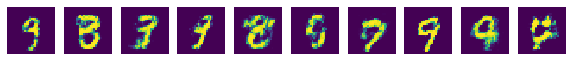

Epoch: 0080 D loss: -0.6468 G loss: -2.306


<Figure size 432x288 with 0 Axes>

Epoch: 0081 D loss: -0.7915 G loss: -2.018


<Figure size 432x288 with 0 Axes>

Epoch: 0082 D loss: -0.6527 G loss: -2.246


<Figure size 432x288 with 0 Axes>

Epoch: 0083 D loss: -0.6237 G loss: -1.947


<Figure size 432x288 with 0 Axes>

Epoch: 0084 D loss: -0.5654 G loss: -2.1


<Figure size 432x288 with 0 Axes>

Epoch: 0085 D loss: -0.631 G loss: -2.095


<Figure size 432x288 with 0 Axes>

Epoch: 0086 D loss: -0.7423 G loss: -1.951


<Figure size 432x288 with 0 Axes>

Epoch: 0087 D loss: -0.5724 G loss: -2.084


<Figure size 432x288 with 0 Axes>

Epoch: 0088 D loss: -0.6789 G loss: -2.207


<Figure size 432x288 with 0 Axes>

Epoch: 0089 D loss: -0.7448 G loss: -2.161


<Figure size 432x288 with 0 Axes>

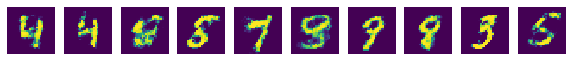

Epoch: 0090 D loss: -0.6192 G loss: -2.175


<Figure size 432x288 with 0 Axes>

Epoch: 0091 D loss: -0.6227 G loss: -2.353


<Figure size 432x288 with 0 Axes>

Epoch: 0092 D loss: -0.6023 G loss: -2.154


<Figure size 432x288 with 0 Axes>

Epoch: 0093 D loss: -0.5682 G loss: -2.423


<Figure size 432x288 with 0 Axes>

Epoch: 0094 D loss: -0.6429 G loss: -2.266


<Figure size 432x288 with 0 Axes>

Epoch: 0095 D loss: -0.5106 G loss: -2.19


<Figure size 432x288 with 0 Axes>

Epoch: 0096 D loss: -0.6673 G loss: -2.161


<Figure size 432x288 with 0 Axes>

Epoch: 0097 D loss: -0.5856 G loss: -2.614


<Figure size 432x288 with 0 Axes>

Epoch: 0098 D loss: -0.5915 G loss: -2.109


<Figure size 432x288 with 0 Axes>

Epoch: 0099 D loss: -0.7458 G loss: -2.23


<Figure size 432x288 with 0 Axes>

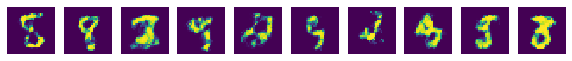

최적화 완료


<Figure size 432x288 with 0 Axes>

In [20]:
for epoch in range(total_epoch):
    for i in range(total_batch):
      batch_xs, batch_ys = mnist.train.next_batch(batch_size)
      noise = get_noise(batch_size,n_noise)
      
      _, loss_val_D = sess.run([train_D, loss_D], feed_dict={X: batch_xs, Z: noise})
      _, loss_val_G = sess.run([train_G, loss_G], feed_dict={Z: noise})

    print('Epoch:', '%04d' % epoch,'D loss: {:.4}'.format(loss_val_D),'G loss: {:.4}'.format(loss_val_G))
    
    if epoch == 0 or (epoch+1)% 10 == 0: ##0,9,19..번째마다 생성자가 만든 이미지를 출력해봅시다.
      sample_size = 10
      noise = get_noise(sample_size, n_noise)
      samples = sess.run(G, feed_dict={Z: noise})

      fig,ax = plt.subplots(1,sample_size, figsize=(sample_size,1))
    
    for i in range(sample_size): ##위의 0,9,19..번째의 결과값을 28x28크기의 이미지로 만들어 samples폴더에 저장하고 보여줍니다. samples폴더는 미리 만들어져있어야 합니다.
      ax[i].set_axis_off()
      ax[i].imshow(np.reshape(samples[i],(28,28)))
    plt.show()
    plt.savefig('samples/{}.png'.format(str(epoch).zfill(3)),bbox_inches= 'tight')
    plt.close(fig)

print('최적화 완료')